# Latent Dirichlet Allocation (LDA)

LDA это вероятностная тематическая модель. Совместное распределение имеет следующий вид:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Где:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Categorical(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Categorical(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

В данном задании, вам предстоит применить тематическую модель LDA к датасету NIPS-papers. Нужно установить Python библиотеку `gensim` (её можно установить с помощью `pip`).

In [13]:
import numpy as np
import scipy.io
from matplotlib import pyplot
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

Скачайте датасет и поместите его в папку с ноутбуком: 
http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

Код ниже выполняет необходимую предобработку данных.

In [2]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# матрица размера <число документов> x <число слов>
counts = nips12['counts'].T

# оставим 2013 (~2000) наиболее употребимих слов
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# отображение id -> word (необходимо для gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# отображение word -> id (необходимо для pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# Год проведения конференции. Значение 0 соответсвует 1988, 1 - 1989, и т.д.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Заголовки статей
nips12_titles = nips12['ptitles']

# Полный корпус в формате gensim
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Маленький корпус из 10% случайных статей для ускорения экспериментов
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim использует итеративный подход к выводу в модели LDA. Для получения новых значений вариационных параметров выполняется `iterations` итераций вариационного вывода. Далее, новые значения "блэндятся" со старыми (значениями из предыдущей итерации EM-алгоритма) посредством вычисления взвешенного среднего. Эта процедура повторяется `num_passes` раз. Такой подход позволяет предотвратить "застревание" метода в локальных оптимумах.

Используйте следующий шаблон для запуска LDA модели в Gensim. Сейчас мы используем подвыборку для ускорения вычислений.

Замечание: нижняя оценка связана с метрикой perplexity, которая обычно используется в естественных языках: $perplexity = exp(-bound)$

In [3]:
num_topics = 10  # число тем в модели LDA
alpha = [0.1] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 50  # число итераций вариационного вывода
num_passes = 5  # число проходов по датасету


small_lda = gensim.models.LdaModel(
    corpus=small_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42
)
print('ELBO = {0:.4f}'.format(small_lda.bound(small_corpus)))

ELBO = -1494880.4356


Исследуйте влияние значений параметров `iterations` и `num_passes` на значние нижней оценки обученной модели.

In [4]:
for k_iter in [10,50,100,200,500]:
    for k_num_pass in [1,5,10,50]:
        num_topics = 10  # число тем в модели LDA
        alpha = [0.1] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
        iterations = k_iter  # число итераций вариационного вывода
        num_passes = k_num_pass  # число проходов по датасету


        small_lda = gensim.models.LdaModel(
            corpus=small_corpus,
            passes=num_passes,
            num_topics=num_topics,
            alpha=alpha,
            iterations=iterations,
            id2word=nips12_id2word,
            eval_every=0,
            random_state=42
        )
        print('ELBO = {0:.4f}'.format(small_lda.bound(small_corpus)),"iters =",k_iter," passes =",k_num_pass)
    print()

ELBO = -1586290.3050 iters = 10  passes = 1
ELBO = -1529772.1017 iters = 10  passes = 5
ELBO = -1494179.1524 iters = 10  passes = 10
ELBO = -1472561.4558 iters = 10  passes = 50

ELBO = -1559751.5275 iters = 50  passes = 1
ELBO = -1494880.4356 iters = 50  passes = 5
ELBO = -1484833.3776 iters = 50  passes = 10
ELBO = -1473776.3628 iters = 50  passes = 50

ELBO = -1542971.4658 iters = 100  passes = 1
ELBO = -1493718.1972 iters = 100  passes = 5
ELBO = -1484906.4747 iters = 100  passes = 10
ELBO = -1474974.1792 iters = 100  passes = 50

ELBO = -1530357.3863 iters = 200  passes = 1
ELBO = -1492944.8818 iters = 200  passes = 5
ELBO = -1484979.7516 iters = 200  passes = 10
ELBO = -1475573.5036 iters = 200  passes = 50

ELBO = -1524551.9917 iters = 500  passes = 1
ELBO = -1492420.8265 iters = 500  passes = 5
ELBO = -1484744.9940 iters = 500  passes = 10
ELBO = -1475621.4084 iters = 500  passes = 50



При увеличении  `iterations` и `num_passes` значение нижней оценки обученной модели улучшается.

Исследуйте чувствительность нижней вариационную оценки к параметру априорного распределения $\alpha$. Используйте симметричные значения $\alpha$.


Обучите лучшую найденую модель на полной выборке.

In [8]:
num_topics = 10  # число тем в модели LDA
alpha = [0.1] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 10  # число итераций вариационного вывода
num_passes = 50  # число проходов по датасету

lda = gensim.models.LdaModel(
    corpus=full_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42,    
)
print('ELBO = {0:.4f}'.format(lda.bound(full_corpus)))

ELBO = -13807144.2610


Извлеките вариационные параметры $\gamma$ &mdash; параметры вариационной аппроксимации апостериорных вероятностей тем для документов: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Нормализуйте их так, чтобы получить вероятностное распределение над темами для каждого документа (средние значения вероятностей в соответствии с распределением Дирихле).

In [130]:
gamma, _ = lda.inference(full_corpus)
for i in range(gamma.shape[0]):
    norm = np.sum(gamma[i])
    if norm!=0:
        gamma[i]=gamma[i]/norm
#нормализуйте gamma

Изобразите полученное апостериорное распределение вероятностей тем для нескольких документов. Сделайте это для документов разных годов. Меняется ли разреженность тем с течением времени? Как можно это объяснить?


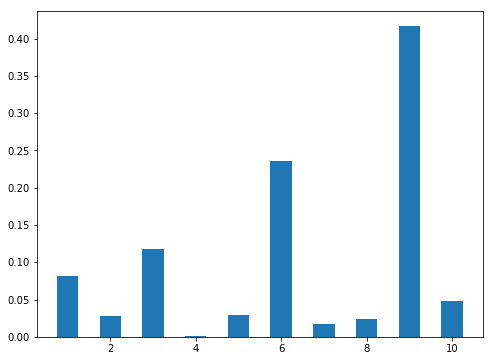

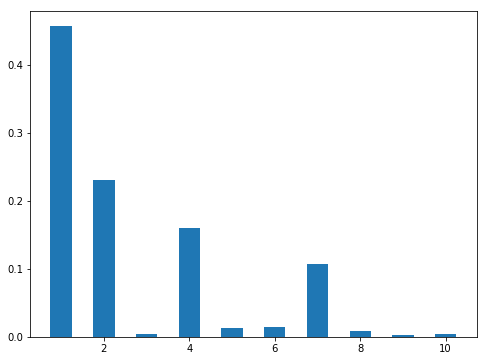

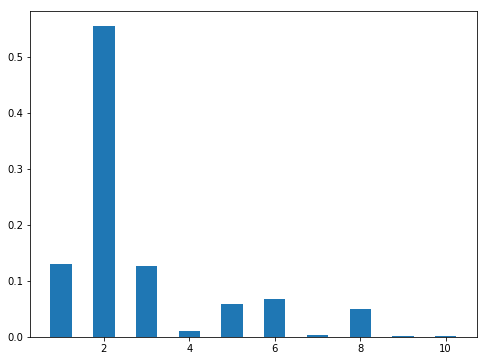

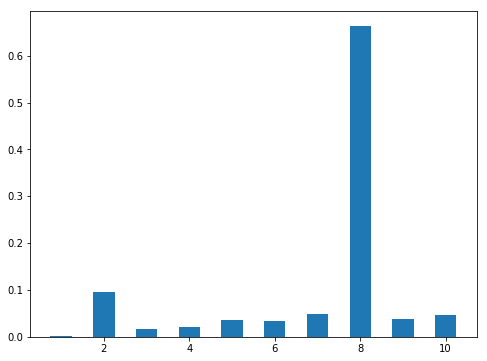

In [179]:
for k in [0,2,4,8]:
    index=np.where(nips12_issue==k)[0][0]
    pyplot.figure(figsize=(8,6))
    pyplot.bar(np.arange(1,11), gamma[index],width=0.5)
    pyplot.show()

Да, разреженность меняется, так как с каждым годом человечество эволюционирует и решает актуальные проблемы, в это же время появляются новые, более масштабные задачи, к которым оно переходит в скором будущем.

Выведите наиболее вероятные слова и наиболее вероятные документы для каждой темы. Воспользуйтесь функциями `lda.num_topics`, `lda.show_topic(topic, topn=10)`. Используйте нормализованные параметры $\gamma$, вычисленные ранее.

Проанализируйте результат. Как вы можете интерпретировать темы? Напишите ваши интерпретации хотя бы для трёх тем.

Замечание. Если вы нашли интересную статью в списке, вы можете скачать её онлайн, публикации конференции NIPS доступны бесплатно.

In [198]:
for i in range(lda.num_topics):
    print(i,nips12_titles[gamma[:,i].argmax()])

0 Silicon Retina with Adaptive Filtering Properties 
1 Can V1 Mechanisms Account for Figure-Ground and Medial Axis Effects ?,
2 The Effect of Eligibility Traces on Finding Optimal Memoryless Policies in Partially Observable Markov Decision Processes,
3 English Alphabet Recognition with Telephone Speech 
4 Learning Sequential Structure in Simple Recurrent Networks 
5 Basins of Attraction for Electronic Neural Networks 
6 Multiplicative Updating Rule for Blind Separation Derived from the Method of Scoring,
7 The Infinite Gaussian Mixture Model,
8 Polynomial Uniform Convergence of Relative Frequencies to Probabilities 
9 Learning with Ensembles: How Overfitting Can Be Useful 


In [65]:
for topic in range(lda.num_topics):
    print(lda.show_topic(topic,topn=10))

[('time', 0.014665185770235151), ('figure', 0.012133659237976409), ('neuron', 0.011716971258808002), ('input', 0.010223360989678645), ('neurons', 0.0093047758908151781), ('circuit', 0.0090885753851831369), ('analog', 0.008848267263732534), ('model', 0.0085101240800716255), ('signal', 0.0084694206268713934), ('spike', 0.0083399698009303282)]
[('model', 0.017951355751468435), ('visual', 0.012858676923608934), ('cells', 0.0099803612201323465), ('figure', 0.0087640085270170674), ('activity', 0.0085478348542668975), ('input', 0.0072140264262197168), ('field', 0.0068363330903312199), ('neurons', 0.0067692853225549124), ('cell', 0.0066180607329626353), ('cortex', 0.0065225152005948927)]
[('learning', 0.032062997338970459), ('state', 0.027733424790472309), ('time', 0.016768913689437039), ('control', 0.015384386924839117), ('model', 0.011796199497791898), ('function', 0.0090540399774253627), ('states', 0.0084341925149483375), ('system', 0.0083815740743571395), ('algorithm', 0.007914243877572104

8ую тему можно интерпретировать как "Байесовские методы в машинном обучении"

10ую как "нейросети"

1ую как "человеческий мозг"

Вычислите среднюю вероятность тем для каждого года. Проанализируйте какие темы становятся более популярны с теченим времени, а какие, наоборот, теряют популярность.

На текущий момент времени самыми актуальными темами являются интерпретация человеческого мозга и нейросети.

Используйте следующий код для отображения тем, найденных LSI (Latent Semantic Indexing) &mdash; невероятностной тематической моделью. Как можно интерпретироват полученные темы? Сравните время работы методов.

In [68]:
lsi = gensim.models.LsiModel(full_corpus, num_topics=num_topics, id2word=nips12_id2word)
lsi.print_topics(10, num_words=20)

[(0,
  '0.293*"network" + 0.263*"learning" + 0.207*"model" + 0.204*"neural" + 0.188*"input" + 0.167*"training" + 0.167*"data" + 0.164*"networks" + 0.162*"time" + 0.161*"function" + 0.158*"set" + 0.152*"figure" + 0.127*"output" + 0.119*"algorithm" + 0.118*"error" + 0.113*"number" + 0.109*"system" + 0.107*"units" + 0.104*"state" + 0.094*"results"'),
 (1,
  '-0.498*"network" + 0.333*"learning" + -0.222*"input" + 0.209*"algorithm" + 0.208*"data" + 0.196*"model" + -0.188*"neural" + -0.167*"networks" + -0.158*"units" + -0.151*"output" + 0.128*"state" + 0.123*"function" + -0.115*"layer" + -0.096*"unit" + -0.090*"neurons" + 0.088*"models" + 0.080*"distribution" + -0.078*"hidden" + 0.077*"policy" + 0.075*"algorithms"'),
 (2,
  '0.473*"model" + -0.238*"training" + -0.228*"learning" + -0.205*"network" + 0.179*"cells" + -0.174*"error" + 0.156*"neurons" + -0.155*"networks" + 0.149*"cell" + 0.147*"visual" + 0.132*"figure" + 0.119*"time" + 0.118*"neuron" + -0.117*"set" + 0.113*"response" + -0.106*"hi

Данный метод работает быстрее.

# Визуализация

Используйте следующий код для изображения тем вашей лучшей модели.

In [31]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

    
class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]



In [32]:
lda.save('model.dat')

Установите библиотеку `pyLDAvis` с помощью `pip`

**Найдите две наиболее похожие темы.**

In [33]:
import pyLDAvis.gensim

lda = gensim.models.LdaModel.load('model.dat')
my_full_corpus = MyScipy2Corpus(counts[subset_mask, :])
my_dictionary = MyDictionary(nips12_word2id)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)

/home/bloodroller/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


Самыми похожими темами оказались "мозг" и "импульсная нейронная сеть"